In [1]:
import sys
import os
import struct
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

fpX = np.float32

import torch 
sys.path.append('/user_data/mmhender/imStat/code/')
root = os.path.dirname(os.path.dirname(os.getcwd()))
from plotting import plot_utils, summary_plots, load_fits, plot_prf_params
plot_utils.set_plotting_defaults()
from utils import roi_utils, nsd_utils, default_paths, stats_utils

In [2]:
# Load results of the fitting procedure

subject = 1
volume_space=True
fitting_type = 'texture_pyramid_ridge_4ori_4sf_pca_HL_plus_sketch_tokens'

root = os.path.dirname(os.path.dirname(os.getcwd()))
out, fig_save_folder = load_fits.load_fit_results(subject, volume_space, fitting_type, n_from_end=0, root=root, verbose=True);
load_fits.print_output_summary(out)

if not os.path.exists(fig_save_folder):
    os.makedirs(fig_save_folder)

loading from /user_data/mmhender/imStat/model_fits/S01/texture_pyramid_ridge_4ori_4sf_pca_HL_plus_sketch_tokens/Nov-09-2021_2229_32/all_fit_params

dict_keys(['subject', 'volume_space', 'fitting_type', 'fitting_type2', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'aperture', 'aperture_rf_range', 'which_prf_grid', 'models', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'partial_masks', 'partial_version_names', 'zscore_features', 'zscore_in_groups', 'ridge', 'debug', 'up_to_sess', 'shuff_rnd_seed', 'use_precomputed_prfs', 'corr_each_feature', 'discrim_each_axis', 'min_pct_var', 'max_pc_to_retain_pyr_ll', 'max_pc_to_retain_pyr_hl', 'use_pca_pyr_feats_ll', 'use_pca_pyr_feats_hl', 'feature_info', 'group_all_hl_feats'])
subject = 1
volume_space = 1
fitting_type = pyramid_texture
fitting_type2 = sketch_tokens
voxel_mask: shape (699192,)
brain_nii_shape: shape (3,)
image_order: shape (15000,)
voxel_index: len 1
voxel_

In [11]:
# roi_def = roi_utils.get_combined_rois(subject,include_all=False,include_body=False,volume_space=True,verbose=False) 
roi_def = roi_utils.get_combined_rois(subject,include_all=True,include_body=True,volume_space=True,verbose=False) 

skip_inds = [10,11,15,23]
retlabs, facelabs, placelabs, bodylabs, \
        ret_names, face_names, place_names, body_names = roi_def


In [5]:
port=33333
summary_plots.plot_summary_pycortex(out=out, subject=subject, fitting_type=fitting_type, \
                                port=port, roi_def=roi_def)

In [10]:
best_models_each_voxel = out['best_params'][5][:,0]

In [14]:
np.where(best_models_each_voxel)[0].shape

(14900,)

In [30]:
voxels_to_fit = np.where(best_models_each_voxel==697)[0]

In [29]:
voxels_to_fit = np.arange(0,22)
voxel_batch_size=7

In [31]:
n_voxels_to_fit = len(voxels_to_fit)            
n_batches = int(np.ceil(n_voxels_to_fit/voxel_batch_size))

for vi in range(n_batches):

    vinds = np.arange(voxel_batch_size*vi, np.min([voxel_batch_size*(vi+1), n_voxels_to_fit]))
    rv = voxels_to_fit[vinds]
    lv = len(vinds)

#     sys.stdout.write('\rfitting model %4d of %-4d, voxel batch %d of %d'%(0, 0, vi, n_batches))
    print(vinds)
    print(rv)

[0 1 2 3 4 5 6]
[  21 1199 1244 1488 1616 3008 3147]
[ 7  8  9 10 11 12 13]
[3487 3613 3828 4075 4257 4328 4428]
[14 15 16 17 18 19 20]
[4698 4719 4720 4752 4774 5087 5690]
[21 22 23 24 25 26 27]
[ 5816  6410  7153 10294 10774 11246 11913]
[28 29]
[12850 14435]


In [33]:
voxels_to_fit

array([   21,  1199,  1244,  1488,  1616,  3008,  3147,  3487,  3613,
        3828,  4075,  4257,  4328,  4428,  4698,  4719,  4720,  4752,
        4774,  5087,  5690,  5816,  6410,  7153, 10294, 10774, 11246,
       11913, 12850, 14435])

In [36]:
imp = np.ones((lv,))==1
imp

array([ True,  True])

In [4]:
from plotting_and_analysis import stats_utils, spatial_fits

port=33333

retlabs, catlabs, ret_group_names, categ_group_names = stats_utils.get_combined_rois(subject, out)
best_ecc_deg, best_angle_deg, best_size_deg = spatial_fits.get_prf_pars_deg(out, screen_eccen_deg=8.4)

names0 = ['pRF eccentricity', 'pRF angle', 'pRF size']
maps0 = [best_ecc_deg, best_angle_deg, best_size_deg]
cmaps0 = ['PRGn', 'Retinotopy_RYBCR', 'PRGn']
mins0 = [0,0,0]
maxes0 = [7, 360, 4]

In [4]:
categ_group_names

['OFA', 'FFA-1', 'FFA-2', 'mTL-faces', 'aTL-faces', 'OPA', 'PPA', 'RSC']

In [5]:
bad_voxels = out['val_r2'][:,0]<0

pp0 = 1
pp1 = 2
pp2 = 3

val_r2 = out['val_r2']
shared_ab, unique_a, unique_b = stats_utils.get_shared_unique_var(val_r2[:,pp0], val_r2[:,pp1], val_r2[:,pp2])
var_expl = np.concatenate((val_r2[:,pp0:pp0+1], unique_a[:,np.newaxis], unique_b[:,np.newaxis],shared_ab[:,np.newaxis]),axis=1)
var_expl[bad_voxels,:] = np.nan

max_ind = (np.argmax(var_expl[:,1:3], axis=1)+1).astype(np.float32)
max_ind[bad_voxels] = np.nan

maps1 = [copy.deepcopy(np.sqrt(var_expl[:,ii])) for ii in range(4)] + [copy.deepcopy(max_ind)]

names1 = ['Full pyramid texture model','Unique var: LL texture', 'Unique var: HL texture', 'Shared LL/HL', \
          'Unique var greater for LL or HL']
cmaps1 = ['PuBu', 'PuBu', 'PuBu', 'PuBu', 'plasma_r']
mins1 = [0, 0, 0, 0, 0]
maxes1 = [0.8, 0.8, 0.8, 0.8, 3]

/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app


In [6]:
bad_voxels = out['val_r2'][:,0]<0

pp0 = 0
pp1 = 1
pp2 = 6

val_r2 = out['val_r2']
shared_ab, unique_a, unique_b = stats_utils.get_shared_unique_var(val_r2[:,pp0], val_r2[:,pp1], val_r2[:,pp2])
var_expl = np.concatenate((val_r2[:,pp0:pp0+1], unique_a[:,np.newaxis], unique_b[:,np.newaxis],shared_ab[:,np.newaxis]),axis=1)
var_expl[bad_voxels,:] = np.nan

max_ind = (np.argmax(var_expl[:,1:3], axis=1)+2).astype(np.float32)
max_ind[max_ind==2] = 1.5

max_ind[bad_voxels] = np.nan

maps2 = [copy.deepcopy(np.sqrt(var_expl[:,ii])) for ii in range(4)] + [copy.deepcopy(max_ind)]

names2 = ['Full mid-level model','Unique var: pyramid texture', 'Unique var: contour', 'Shared texture/contour', \
          'Unique var greater for texture or contour']
cmaps2 = ['PuBu', 'PuBu', 'PuBu', 'PuBu', 'plasma_r']
mins2 = [0, 0, 0, 0, 0]
maxes2 = [0.8, 0.8, 0.8, 0.8, 3]

/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt


In [7]:
bad_voxels = out['val_r2'][:,0]<0

ppinds = [5, 4, 1]
r2 = out['val_r2']
var_expl = r2[:,0:1] - r2[:,ppinds]
var_expl[bad_voxels,:] = np.nan

max_ind = (np.argmax(var_expl, axis=1)+1).astype(np.float32)

max_ind[bad_voxels] = np.nan

maps3 = [copy.deepcopy(np.sqrt(var_expl[:,ii])) for ii in range(3)] + [copy.deepcopy(max_ind)]

names3 = ['Unique var each: LL texture', 'Unique var each: HL texture', 'Unique var each: Sketch tokens', \
          'Unique var greatest for LL texture, HL texture, or contour']

cmaps3 = ['PuBu', 'PuBu', 'PuBu','plasma_r']
mins3 = [0, 0, 0, 0]
maxes3 = [0.8, 0.8, 0.8, 3]

/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


In [8]:
[np.where(np.isnan(maps3[ii])) for ii in range(4)]

[(array([    0,     1,     2, ..., 14910, 14911, 14912]),),
 (array([    0,     1,     2, ..., 14910, 14911, 14912]),),
 (array([    3,     4,     7, ..., 14907, 14910, 14912]),),
 (array([    3,     4,     8, ..., 14907, 14910, 14912]),)]

In [9]:
var_expl

array([[-4.1787419e-03, -1.2043230e-02,  6.6781216e-03],
       [-1.1164269e-02, -1.3810639e-02,  2.5201929e-03],
       [-1.6539842e-03, -8.1843678e-03,  1.8133599e-02],
       ...,
       [           nan,            nan,            nan],
       [-7.3463423e-05, -1.4087608e-02,  7.8867013e-03],
       [           nan,            nan,            nan]], dtype=float32)

In [12]:
maps = maps0+maps1+maps2+maps3
cmaps=cmaps0+cmaps1+cmaps2+cmaps3
names=names0+names1+names2+names3
mins=mins0+mins1+mins2+mins3
maxes=maxes0+maxes1+maxes2+maxes3

plot_maps_pycortex(maps, names, subject, out, fitting_type, port, cmaps=cmaps, mins=mins, maxes=maxes)

Data is in 3d volume space
navigate browser to: 127.0.0.1:33333
Started server on port 33333


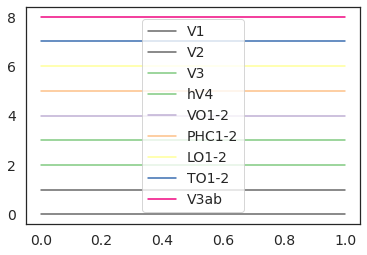

In [25]:
plt.figure();
colors = cm.Accent(np.linspace(0,1,10))
for cc in range(colors.shape[0]-1):
    plt.plot([0,1], [cc,cc], '-',color=colors[cc])
    
plt.legend(ret_group_names[0:10])

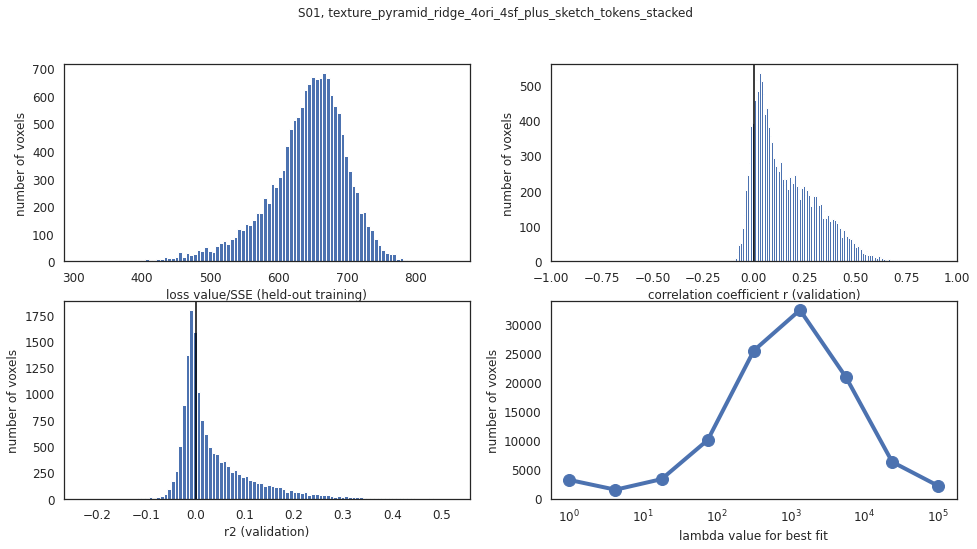

In [5]:
plot_utils.set_all_font_sizes(fs = 12)
summary_plots.plot_perf_summary(subject, fitting_type, out, fig_save_folder=fig_save_folder)

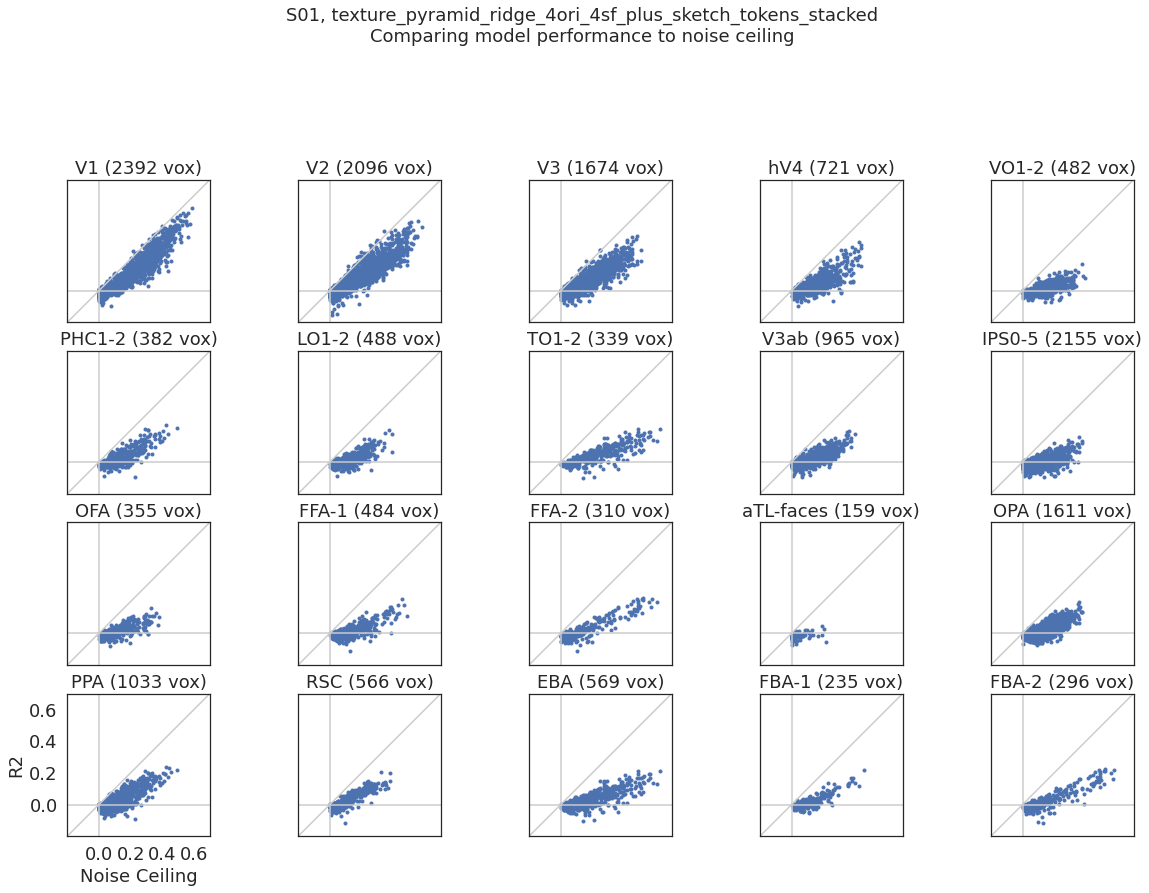

In [13]:
from utils import nsd_utils
plot_utils.set_all_font_sizes(fs = 18)
fig_size=(20,24)
voxel_ncsnr = out['voxel_ncsnr'].ravel()[out['voxel_index'][0]]
noise_ceiling = nsd_utils.ncsnr_to_nc(voxel_ncsnr)/100
# val_r2 = np.sign(out['val_cc'][:,0])*out['val_cc'][:,0]**2
val_r2 = out['val_r2'][:,0]
inds2use = np.ones(np.shape(val_r2))==1

sp = plot_utils.scatter_plot(color=None, xlabel='Noise Ceiling', ylabel='R2', xlims=[-0.2, 0.7], ylims=[-0.2, 0.7], \
                  xticks=[0, 0.2, 0.4, 0.6], yticks=[0, 0.2, 0.4, 0.6],\
                                                        show_diagonal=True, show_axes=True);

if fig_size is None:
    fig_size = (20,18)
plot_utils.create_roi_subplots(np.concatenate([noise_ceiling[:,np.newaxis],val_r2[:,np.newaxis]], axis=1), inds2use, sp, subject, out,\
                    suptitle='S%02d, %s\nComparing model performance to noise ceiling'%(subject, fitting_type), \
                   label_just_corner=True, figsize=fig_size, roi_def=roi_def, skip_inds=skip_inds)
plt.gcf().subplots_adjust(bottom=0.5)
if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'r2_concat_vs_noiseceiling.png'))
    plt.savefig(os.path.join(fig_save_folder,'r2_concat_vs_noiseceiling.pdf'))



In [14]:
out['partial_version_names']

['full_combined_model',
 'just_pyramid_texture',
 'pyramid_texture_just_lower-level_no_other_modules',
 'pyramid_texture_just_higher-level_no_other_modules',
 'pyramid_texture_just_lower-level_plus_other_modules',
 'pyramid_texture_just_higher-level_plus_other_modules',
 'just_sketch_tokens']

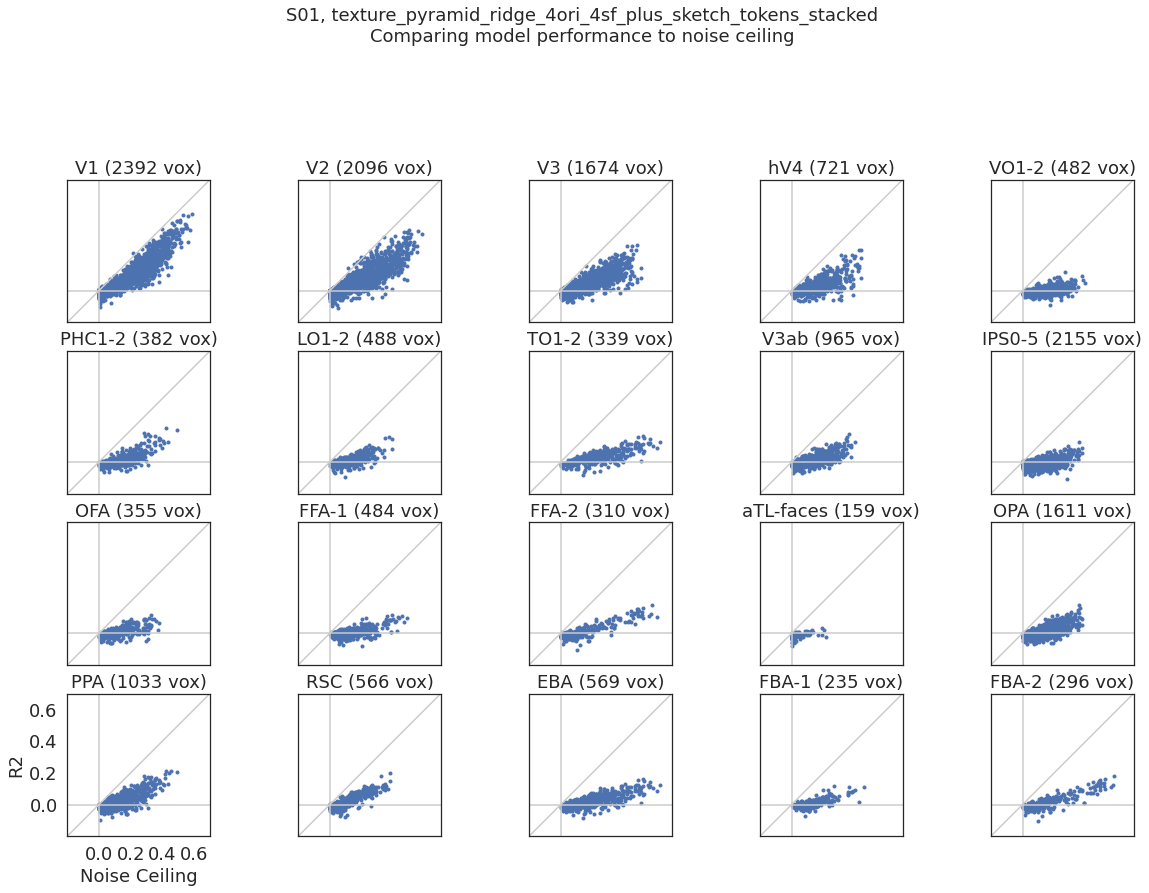

In [15]:
from utils import nsd_utils
plot_utils.set_all_font_sizes(fs = 18)
fig_size=(20,24)
voxel_ncsnr = out['voxel_ncsnr'].ravel()[out['voxel_index'][0]]
noise_ceiling = nsd_utils.ncsnr_to_nc(voxel_ncsnr)/100
# val_r2 = np.sign(out['val_cc'][:,1])*out['val_cc'][:,1]**2
val_r2 = out['val_r2'][:,1]
inds2use = np.ones(np.shape(val_r2))==1

sp = plot_utils.scatter_plot(color=None, xlabel='Noise Ceiling', ylabel='R2', xlims=[-0.2, 0.7], ylims=[-0.2, 0.7], \
                  xticks=[0, 0.2, 0.4, 0.6], yticks=[0, 0.2, 0.4, 0.6],\
                                                        show_diagonal=True, show_axes=True);

if fig_size is None:
    fig_size = (20,18)
plot_utils.create_roi_subplots(np.concatenate([noise_ceiling[:,np.newaxis],val_r2[:,np.newaxis]], axis=1), inds2use, sp, subject, out,\
                    suptitle='S%02d, %s\nComparing model performance to noise ceiling'%(subject, fitting_type), \
                   label_just_corner=True, figsize=fig_size, roi_def=roi_def, skip_inds=skip_inds)
plt.gcf().subplots_adjust(bottom=0.5)
if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'r2_textureonly_vs_noiseceiling.png'))
    plt.savefig(os.path.join(fig_save_folder,'r2_textureonly_vs_noiseceiling.pdf'))



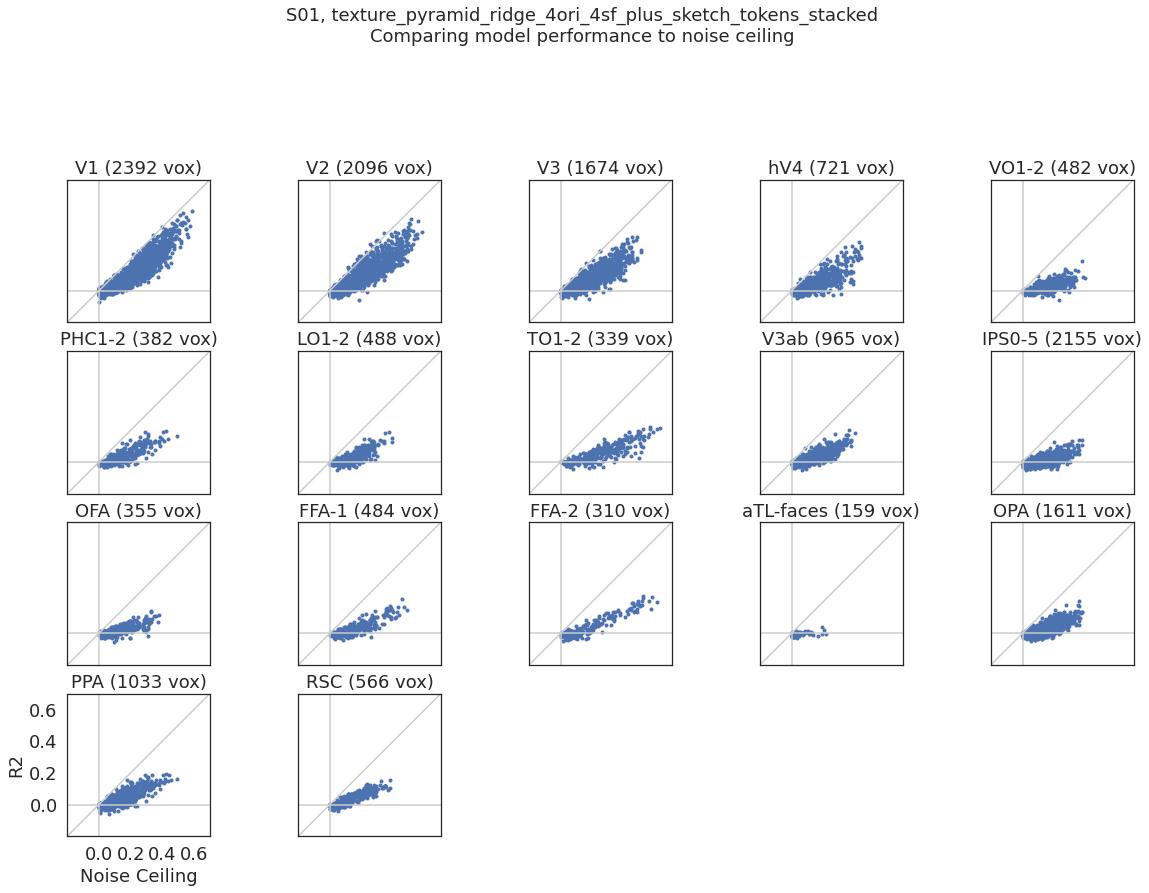

In [5]:
from utils import nsd_utils
plot_utils.set_all_font_sizes(fs = 18)
fig_size=(20,24)
voxel_ncsnr = out['voxel_ncsnr'].ravel()[out['voxel_index'][0]]
noise_ceiling = nsd_utils.ncsnr_to_nc(voxel_ncsnr)/100
# val_r2 = np.sign(out['val_cc'][:,0])*out['val_cc'][:,0]**2
val_r2 = out['val_r2'][:,6]
inds2use = np.ones(np.shape(val_r2))==1

sp = plot_utils.scatter_plot(color=None, xlabel='Noise Ceiling', ylabel='R2', xlims=[-0.2, 0.7], ylims=[-0.2, 0.7], \
                  xticks=[0, 0.2, 0.4, 0.6], yticks=[0, 0.2, 0.4, 0.6],\
                                                        show_diagonal=True, show_axes=True);

if fig_size is None:
    fig_size = (20,18)
plot_utils.create_roi_subplots(np.concatenate([noise_ceiling[:,np.newaxis],val_r2[:,np.newaxis]], axis=1), inds2use, sp, subject, out,\
                    suptitle='S%02d, %s\nComparing model performance to noise ceiling'%(subject, fitting_type), \
                   label_just_corner=True, figsize=fig_size)
plt.gcf().subplots_adjust(bottom=0.5)
if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'r2_STonly_vs_noiseceiling.png'))
    plt.savefig(os.path.join(fig_save_folder,'r2_STonly_vs_noiseceiling.pdf'))



In [22]:
np.array(out['partial_version_names'])[[5,4,1]]

array(['pyramid_texture_just_higher-level_plus_other_modules',
       'pyramid_texture_just_lower-level_plus_other_modules',
       'just_pyramid_texture'], dtype='<U52')

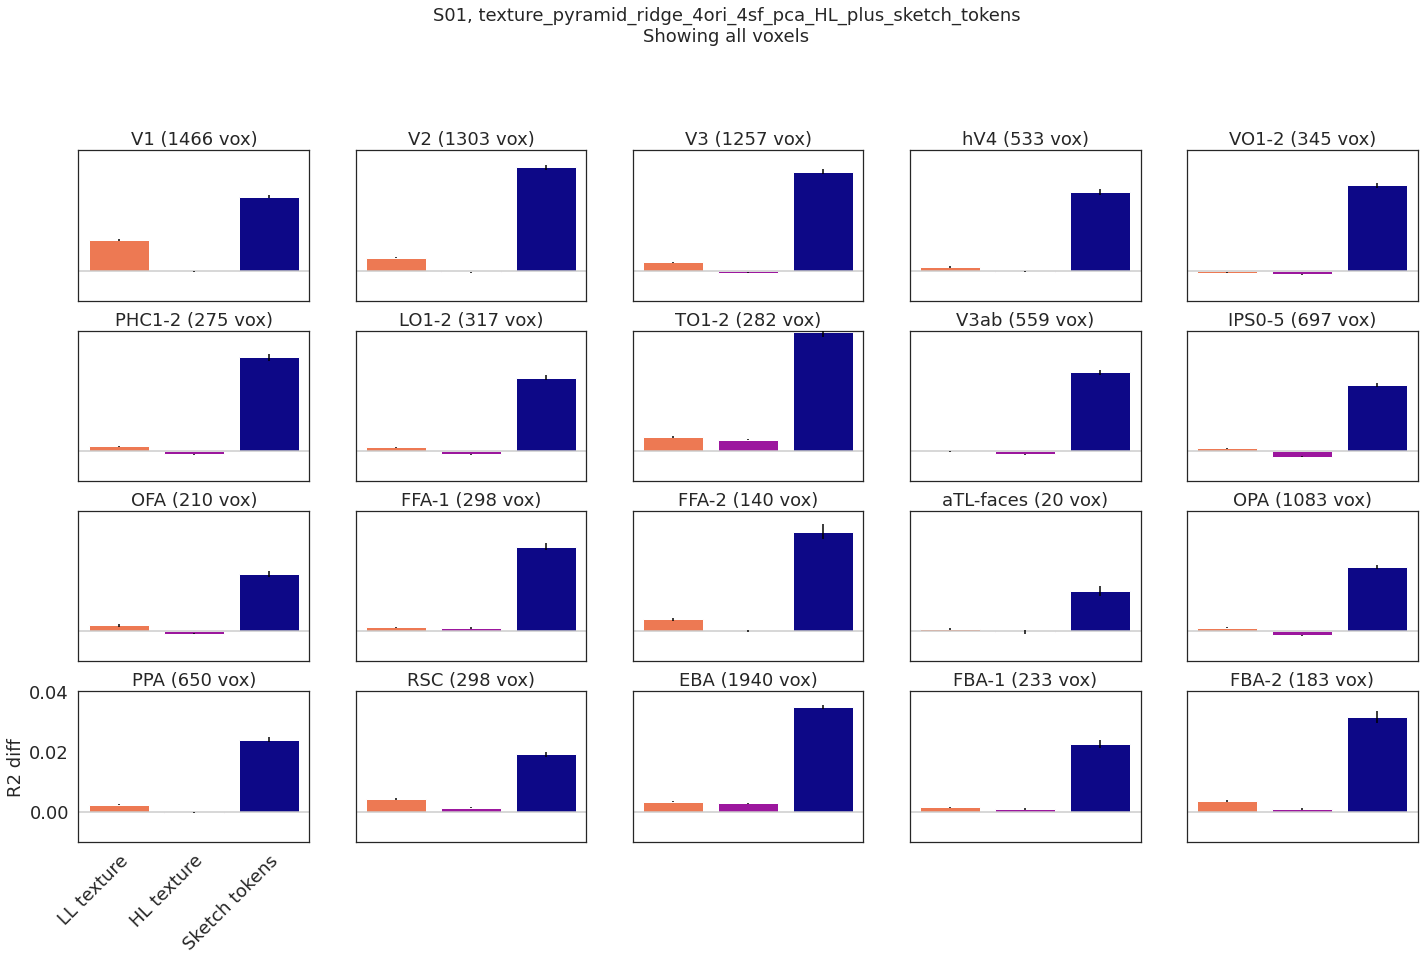

In [19]:
# Plotting unique variance explained by each feature set, using the concatenated model

plot_utils.set_all_font_sizes(fs = 18)

ve_names = ['LL texture', 'HL texture', 'Sketch tokens']

ppinds = [5, 4, 1]
r2 = out['val_r2']
# r2 = np.sign(out['val_cc'])*out['val_cc']**2
var_expl = r2[:,0:1] - r2[:,ppinds]


colors = cm.plasma(np.linspace(0,1,4))[0:-1]
colors = np.flipud(colors)
# colors = np.concatenate((np.array([[0.6, 0.6, 0.6, 1]]), colors[1:,:]), axis=0)

inds2use = val_r2[:,0]>0.01
# inds2use = np.ones(np.shape(var_expl)[0])==1

bp = plot_utils.bar_plot(colors=colors, column_labels=ve_names, ylabel='R2 diff', \
                                                        horizontal_line_pos=0, ylims = [-0.01, 0.04])
plot_utils.create_roi_subplots(var_expl, inds2use, bp, subject, out, roi_def=roi_def, skip_inds=skip_inds,\
                    suptitle='S%02d, %s\nShowing all voxels'%(subject, fitting_type))

plt.gcf().subplots_adjust(bottom=0.4)
if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'Varexpl_each_concat_bar_eachroi.pdf'))
    plt.savefig(os.path.join(fig_save_folder,'Varexpl_each_concat_bar_eachroi.png'))
    


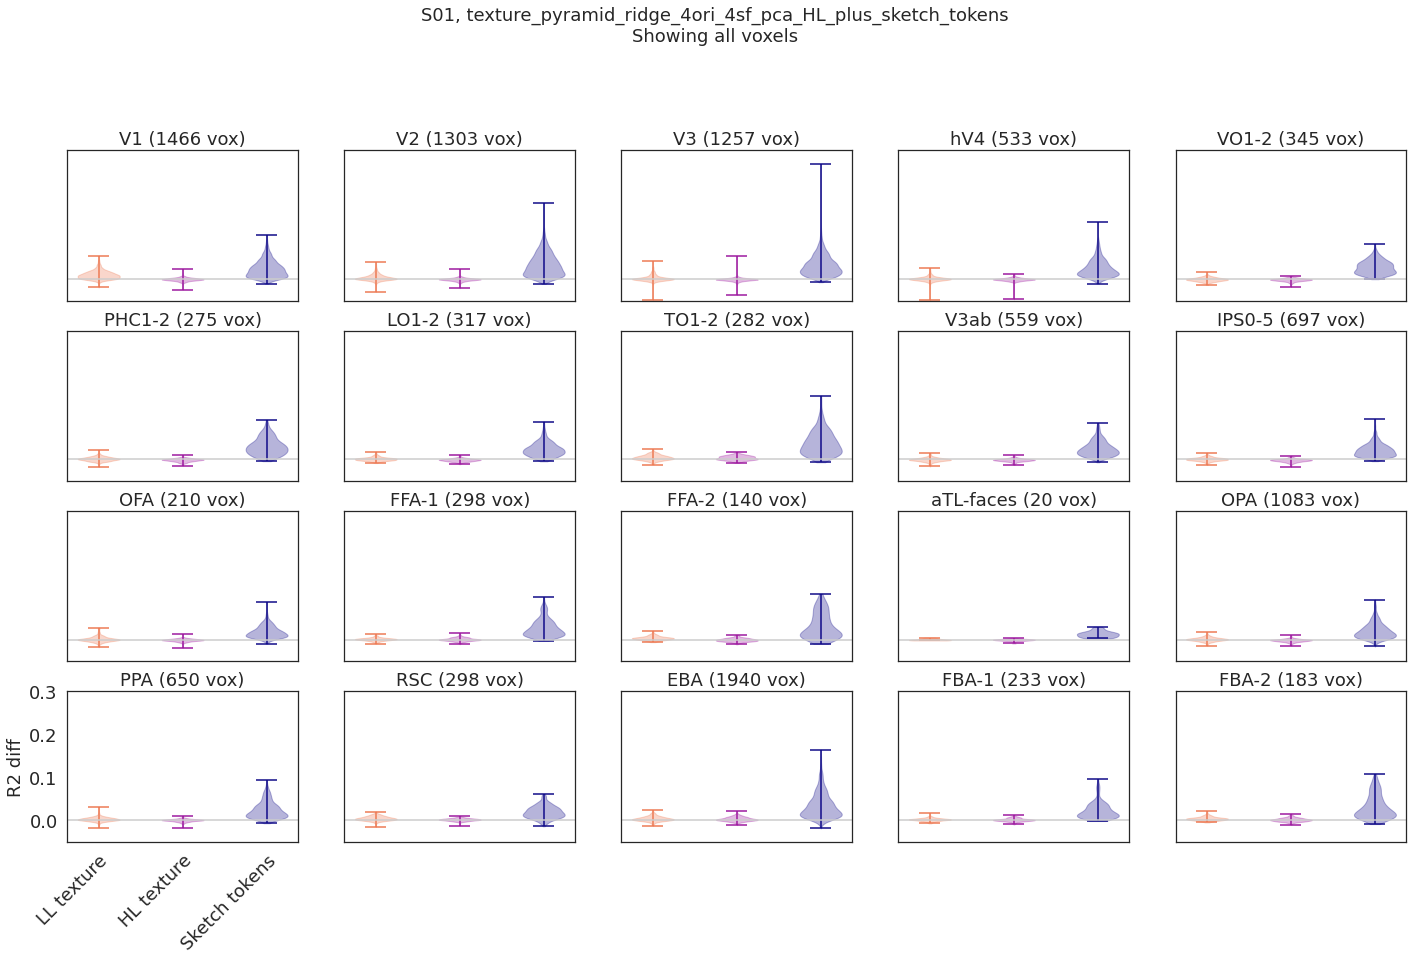

In [18]:
# Plotting unique variance explained by each feature set, using the concatenated model

plot_utils.set_all_font_sizes(fs = 18)

ve_names = ['LL texture', 'HL texture', 'Sketch tokens']

ppinds = [5, 4, 1]
r2 = out['val_r2']
# bad_voxels = r2[:,0]<0
# r2 = np.sign(out['val_cc'])*out['val_cc']**2
var_expl = r2[:,0:1] - r2[:,ppinds]


colors = cm.plasma(np.linspace(0,1,4))[0:-1]
colors = np.flipud(colors)
# colors = np.concatenate((np.array([[0.6, 0.6, 0.6, 1]]), colors[1:,:]), axis=0)

# inds2use = np.ones(np.shape(var_expl)[0])==1
inds2use = val_r2[:,0]>0.01

vp = plot_utils.violin_plot(colors=colors, column_labels=ve_names, ylabel='R2 diff', \
                                                        horizontal_line_pos=0, ylims = [-0.05, 0.30])
plot_utils.create_roi_subplots(var_expl, inds2use, vp, subject, out, roi_def=roi_def, skip_inds=skip_inds,\
                    suptitle='S%02d, %s\nShowing all voxels'%(subject, fitting_type))

plt.gcf().subplots_adjust(bottom=0.4)
if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'Varexpl_each_concat_violin_eachroi.pdf'))
    plt.savefig(os.path.join(fig_save_folder,'Varexpl_each_concat_violin_eachroi.png'))
    


In [6]:
np.array(out['partial_version_names'])[[0,1,6]]

array(['full_combined_model', 'just_pyramid_texture',
       'just_sketch_tokens'], dtype='<U52')

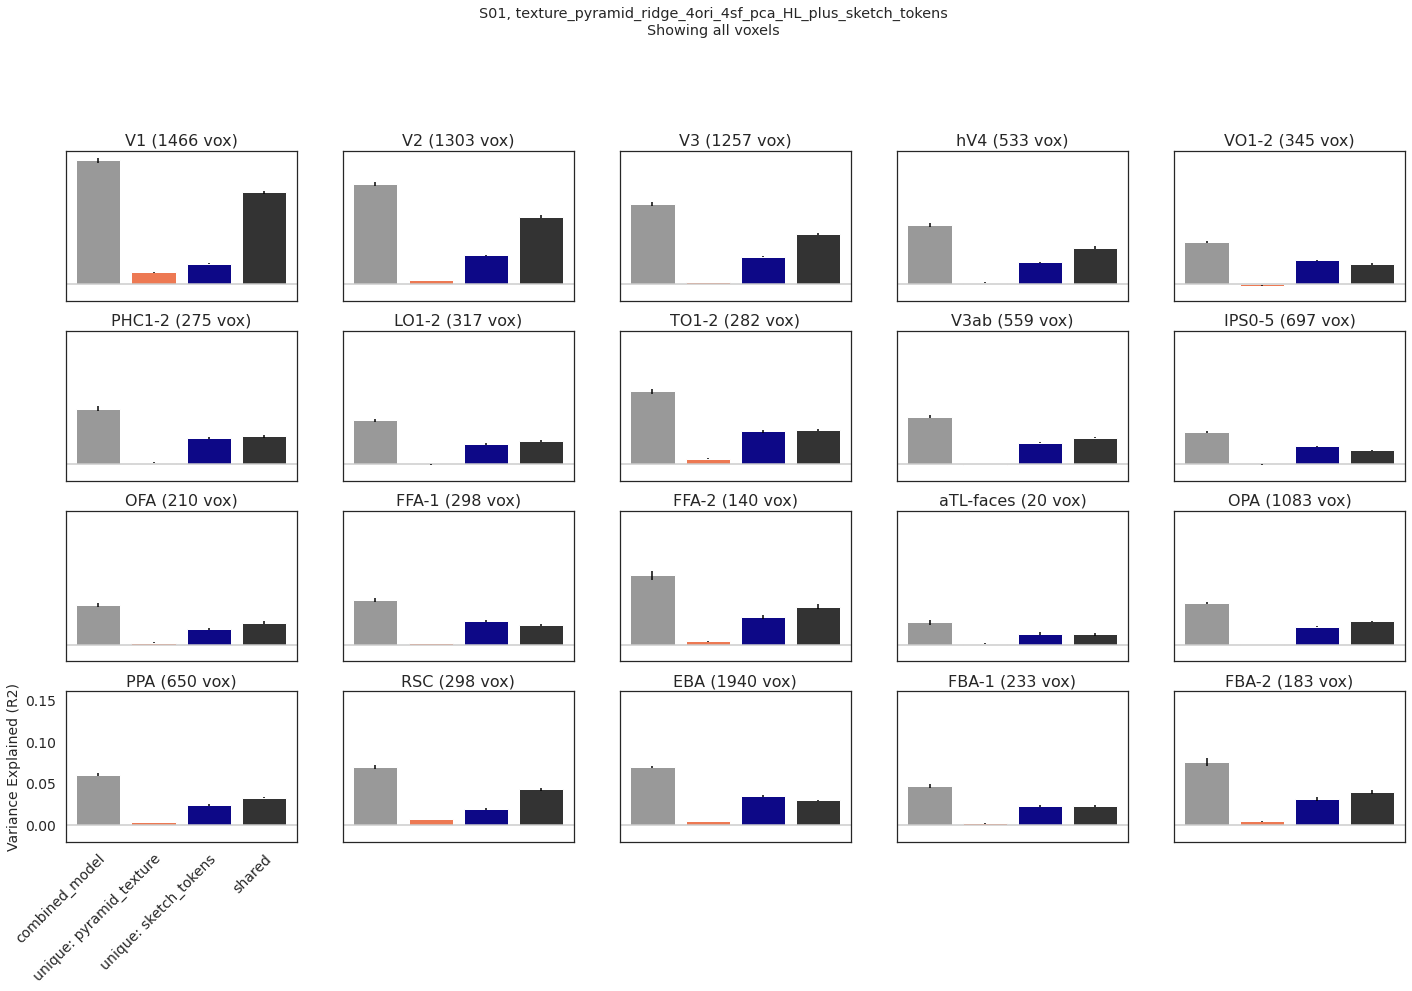

In [12]:
pp0 = 0
pp1 = 1
pp2 = 6

name1 = out['partial_version_names'][pp1][5:]
name2 = out['partial_version_names'][pp2][5:]
# val_r2 = stats_utils.get_r2(out)
val_r2 = out['val_r2']
# val_r2 = np.sign(out['val_cc'])*out['val_cc']**2

ve_names = ['combined_model', 'unique: ' + name1, 'unique: ' + name2, 'shared']
shared_ab, unique_a, unique_b = stats_utils.get_shared_unique_var(val_r2[:,pp0], val_r2[:,pp1], val_r2[:,pp2])

var_expl = np.concatenate((val_r2[:,pp0:pp0+1], unique_a[:,np.newaxis], unique_b[:,np.newaxis],shared_ab[:,np.newaxis]),axis=1)

colors = cm.plasma(np.linspace(0,1,4))
colors = np.flipud(colors)
colors = np.concatenate((np.array([[0.6, 0.6, 0.6, 1]]), colors[[1,3],:], np.array([[0.2, 0.2, 0.2, 1]])), axis=0)

inds2use = val_r2[:,0]>0.01

bp = plot_utils.bar_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                                                        horizontal_line_pos=0, ylims=[-0.02, 0.16])
plot_utils.create_roi_subplots(var_expl, inds2use, bp, subject, out, roi_def=roi_def, skip_inds=skip_inds,\
                    suptitle='S%02d, %s\nShowing all voxels'%(subject, fitting_type))

plt.gcf().subplots_adjust(bottom=0.4)

if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'Varpart_texture_ST_bars_eachroi.pdf'))
    plt.savefig(os.path.join(fig_save_folder,'Varpart_texture_ST_bars_eachroi.png'))

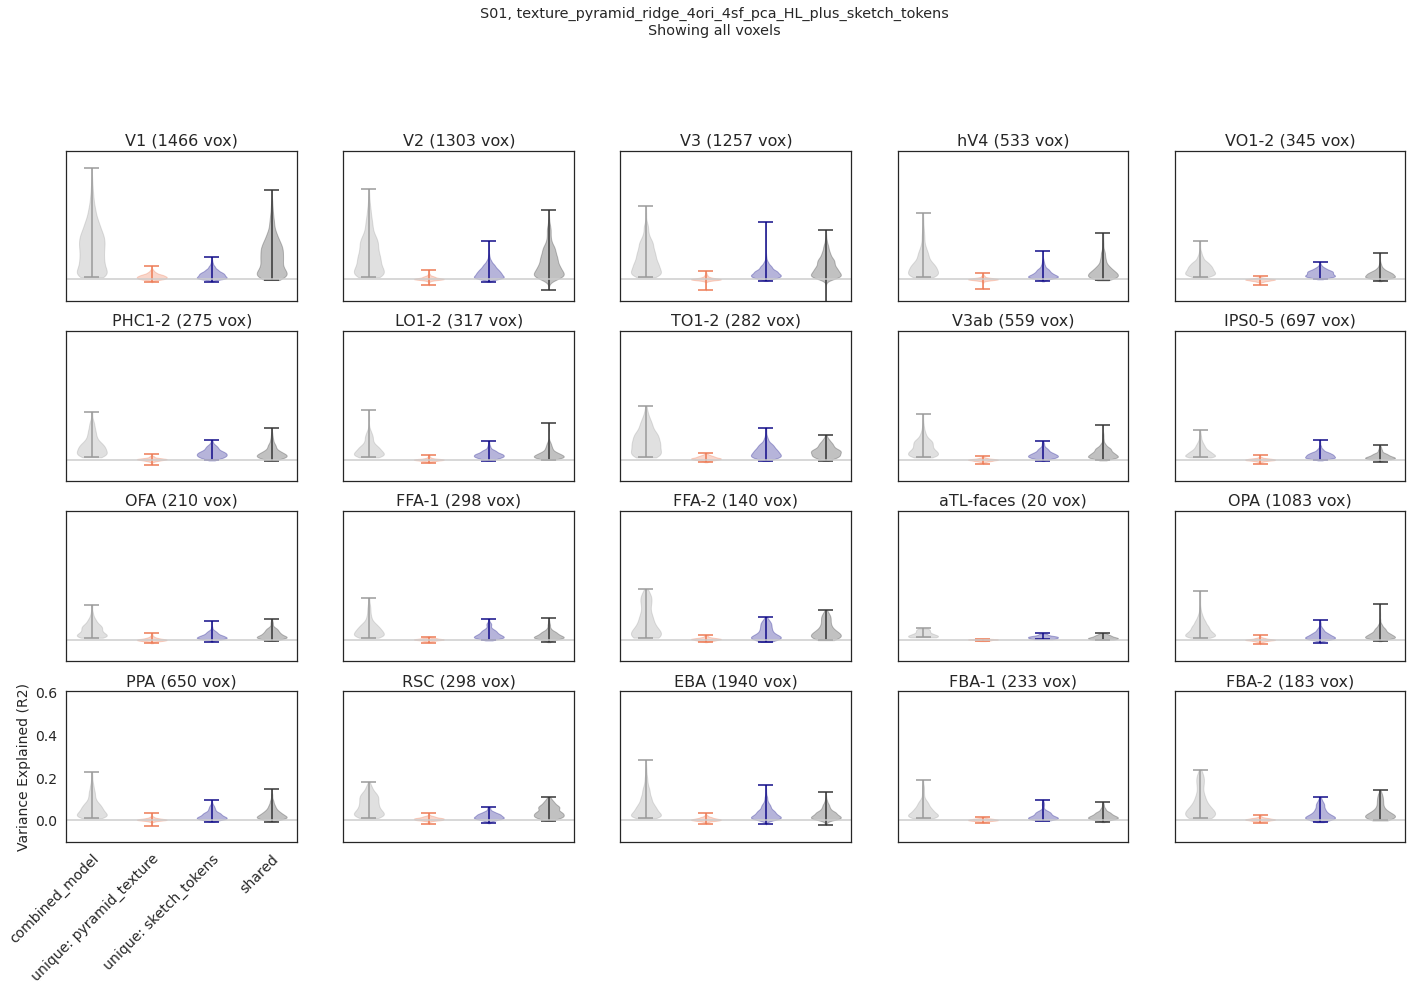

In [14]:
pp0 = 0
pp1 = 1
pp2 = 6

name1 = out['partial_version_names'][pp1][5:]
name2 = out['partial_version_names'][pp2][5:]
# val_r2 = stats_utils.get_r2(out)
val_r2 = out['val_r2']
ve_names = ['combined_model', 'unique: ' + name1, 'unique: ' + name2, 'shared']
shared_ab, unique_a, unique_b = stats_utils.get_shared_unique_var(val_r2[:,pp0], val_r2[:,pp1], val_r2[:,pp2])

var_expl = np.concatenate((val_r2[:,pp0:pp0+1], unique_a[:,np.newaxis], unique_b[:,np.newaxis],shared_ab[:,np.newaxis]),axis=1)

colors = cm.plasma(np.linspace(0,1,4))
colors = np.flipud(colors)
colors = np.concatenate((np.array([[0.6, 0.6, 0.6, 1]]), colors[[1,3],:], np.array([[0.2, 0.2, 0.2, 1]])), axis=0)

inds2use = val_r2[:,0]>0.01

vp = plot_utils.violin_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                                                        horizontal_line_pos=0, ylims=[-0.10, 0.60])
plot_utils.create_roi_subplots(var_expl, inds2use, vp, subject, out, roi_def=roi_def, skip_inds=skip_inds,\
                    suptitle='S%02d, %s\nShowing all voxels'%(subject, fitting_type))

plt.gcf().subplots_adjust(bottom=0.4)

if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'Varpart_texture_ST_violin_eachroi.pdf'))
    plt.savefig(os.path.join(fig_save_folder,'Varpart_texture_ST_violin_eachroi.png'))

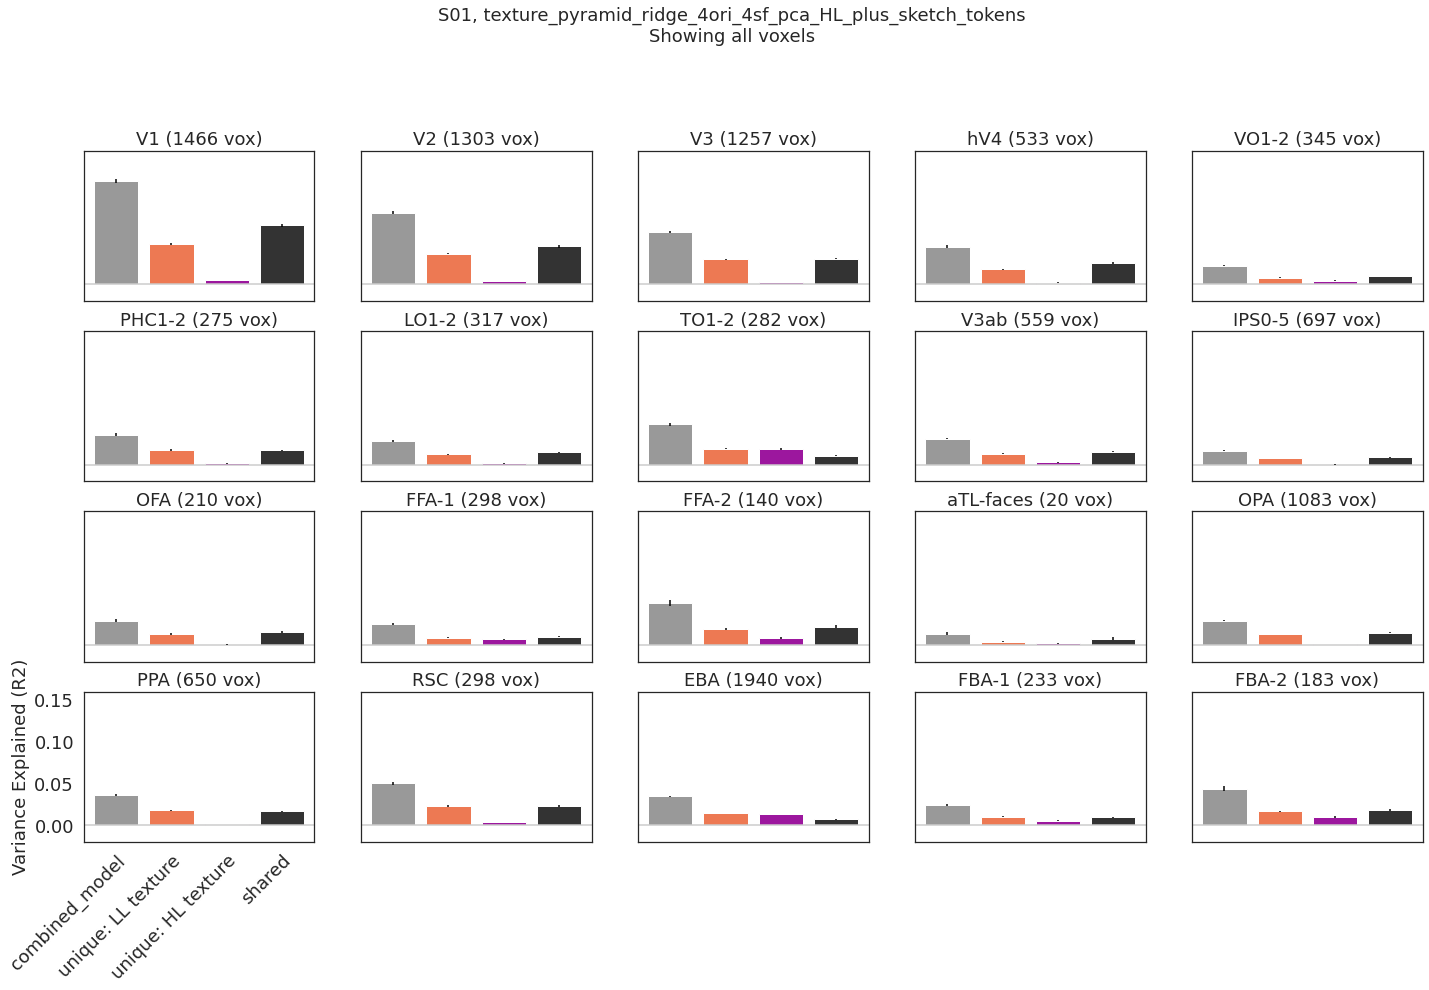

In [21]:
pp0 = 1
pp1 = 2
pp2 = 3

name1 = out['partial_version_names'][pp1][5:]
name2 = out['partial_version_names'][pp2][5:]
# val_r2 = stats_utils.get_r2(out)
val_r2 = out['val_r2']
# val_r2 = np.sign(out['val_cc'])*out['val_cc']**2

ve_names = ['combined_model', 'unique: LL texture', 'unique: HL texture', 'shared']
shared_ab, unique_a, unique_b = stats_utils.get_shared_unique_var(val_r2[:,pp0], val_r2[:,pp1], val_r2[:,pp2])

var_expl = np.concatenate((val_r2[:,pp0:pp0+1], unique_a[:,np.newaxis], unique_b[:,np.newaxis],shared_ab[:,np.newaxis]),axis=1)

colors = cm.plasma(np.linspace(0,1,4))
colors = np.flipud(colors)
colors = np.concatenate((np.array([[0.6, 0.6, 0.6, 1]]), colors[[1,2],:], np.array([[0.2, 0.2, 0.2, 1]])), axis=0)

inds2use = val_r2[:,0]>0.01

bp = plot_utils.bar_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                                                        horizontal_line_pos=0, ylims=[-0.02, 0.16])
plot_utils.create_roi_subplots(var_expl, inds2use, bp, subject, out, roi_def=roi_def, skip_inds=skip_inds,\
                    suptitle='S%02d, %s\nShowing all voxels'%(subject, fitting_type))

plt.gcf().subplots_adjust(bottom=0.4)


if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'Varpart_texture_LL_HL_bars_eachroi.pdf'))
    plt.savefig(os.path.join(fig_save_folder,'Varpart_texture_LL_HL_bars_eachroi.png'))

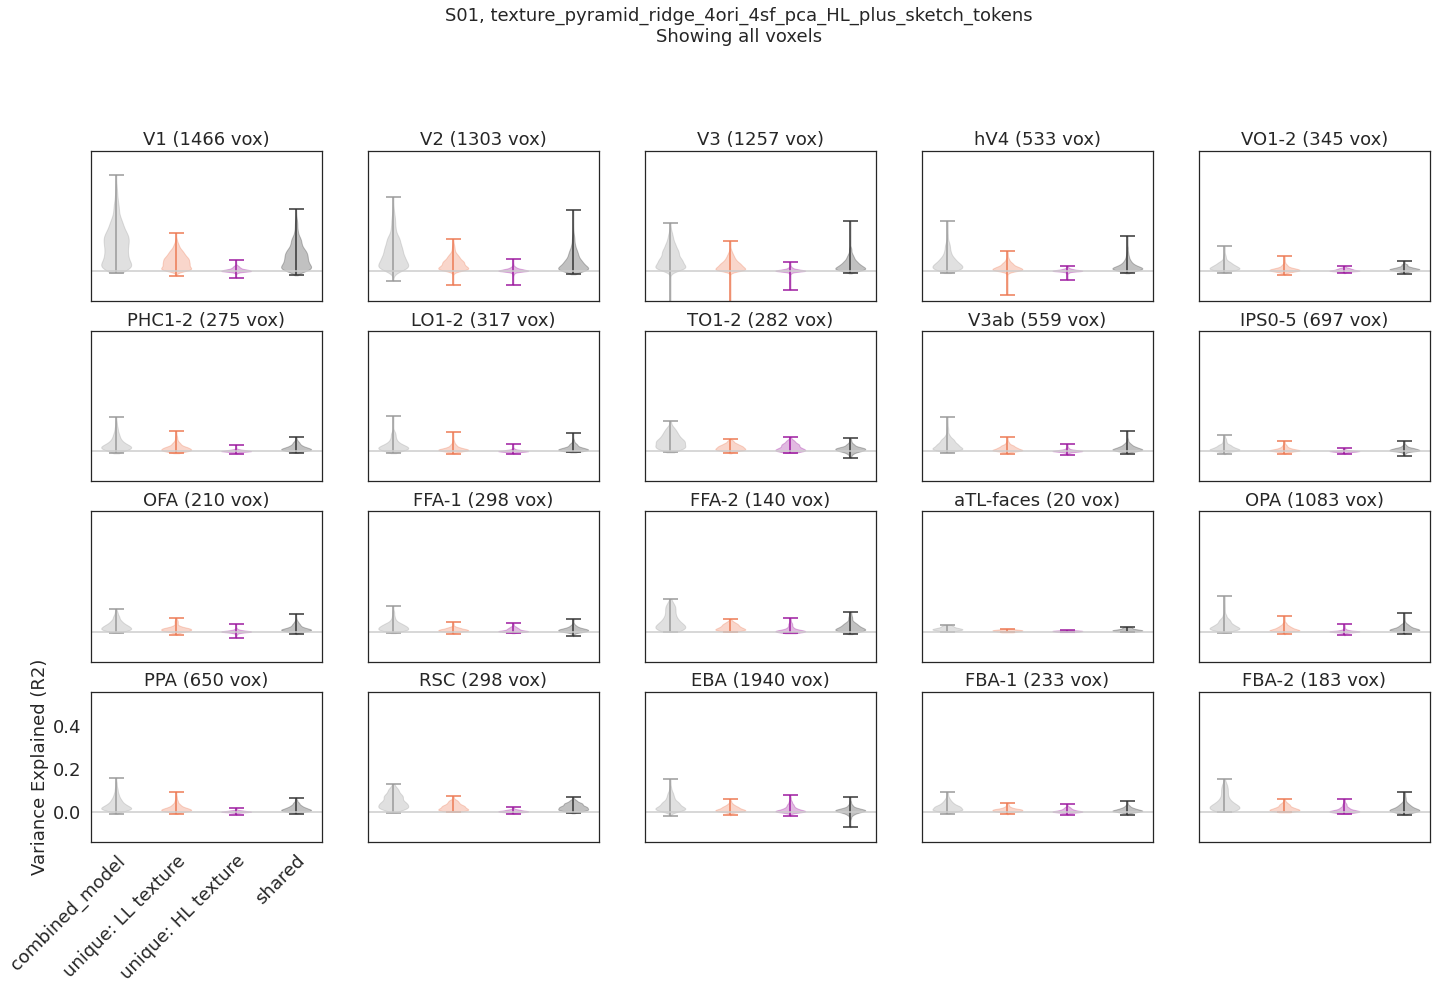

In [20]:
pp0 = 1
pp1 = 2
pp2 = 3
name1 = out['partial_version_names'][pp1][5:]
name2 = out['partial_version_names'][pp2][5:]
# val_r2 = stats_utils.get_r2(out)
val_r2 = out['val_r2']
# val_r2 = np.sign(out['val_cc'])*out['val_cc']**2

ve_names = ['combined_model', 'unique: LL texture', 'unique: HL texture', 'shared']
shared_ab, unique_a, unique_b = stats_utils.get_shared_unique_var(val_r2[:,pp0], val_r2[:,pp1], val_r2[:,pp2])

var_expl = np.concatenate((val_r2[:,pp0:pp0+1], unique_a[:,np.newaxis], unique_b[:,np.newaxis],shared_ab[:,np.newaxis]),axis=1)

colors = cm.plasma(np.linspace(0,1,len(ve_names)))
colors = np.flipud(colors)
colors = np.concatenate((np.array([[0.6, 0.6, 0.6, 1]]), colors[1:3,:], np.array([[0.2, 0.2, 0.2, 1]])), axis=0)

inds2use = val_r2[:,0]>0.01

vp = plot_utils.violin_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                                                        horizontal_line_pos=0, ylims=[-0.14, 0.56])
plot_utils.create_roi_subplots(var_expl, inds2use, vp, subject, out, roi_def=roi_def, skip_inds=skip_inds,\
                    suptitle='S%02d, %s\nShowing all voxels'%(subject, fitting_type))

plt.gcf().subplots_adjust(bottom=0.4)

if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'Varpart_texture_LL_HL_violin_eachroi.pdf'))
    plt.savefig(os.path.join(fig_save_folder,'Varpart_texture_LL_HL_violin_eachroi.png'))

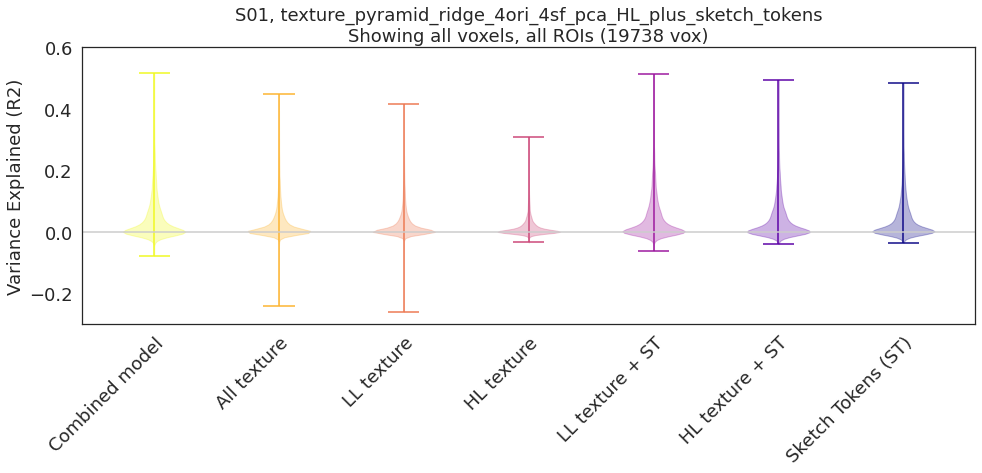

In [23]:
# All individual models, and concat models. 

n_partial_versions = out['partial_masks'].shape[0]
val_cc = out['val_cc']
var_expl = out['val_r2']
ve_names = ['Combined model', 'All texture', 'LL texture', 'HL texture', 'LL texture + ST', 'HL texture + ST','Sketch Tokens (ST)']

colors = cm.plasma(np.linspace(0,1,len(ve_names)))
colors = np.flipud(colors)

inds2use = np.ones(np.shape(val_r2[:,0]))==1

vp = plot_utils.violin_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                 title='S%02d, %s\nShowing all voxels, all ROIs (%d vox)'%(subject, fitting_type, \
                                                        np.sum(inds2use)), \
                                                        horizontal_line_pos=0, ylims=[-0.3, 0.6])
vp.create(data=var_expl[inds2use,:], new_fig=True)

plt.gcf().subplots_adjust(bottom=0.4)
if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'r2_each_submodel_violin_allrois.pdf'))
    plt.savefig(os.path.join(fig_save_folder,'r2_each_submodel_violin_allrois.png'))

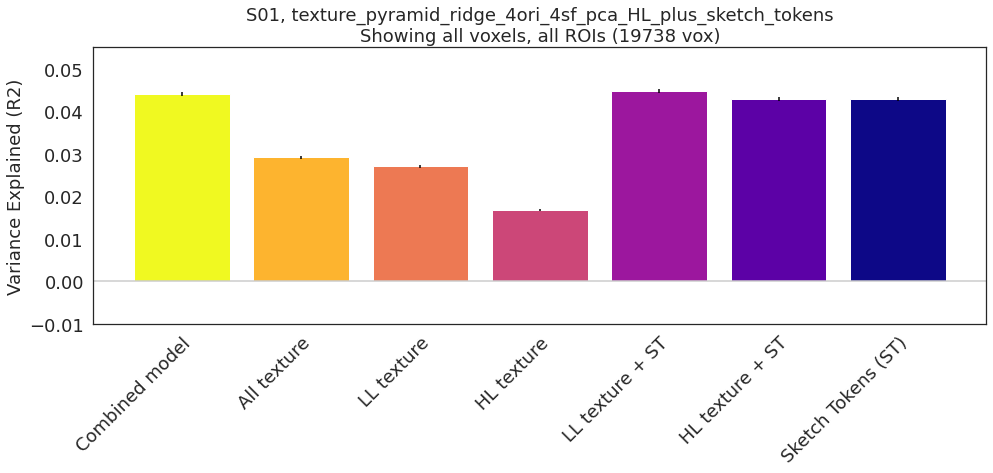

In [22]:

n_partial_versions = out['partial_masks'].shape[0]
var_expl = out['val_r2']
ve_names = ['Combined model', 'All texture', 'LL texture', 'HL texture', 'LL texture + ST', 'HL texture + ST','Sketch Tokens (ST)']

colors = cm.plasma(np.linspace(0,1,len(ve_names)))
colors = np.flipud(colors)

inds2use = np.ones(np.shape(val_r2[:,0]))==1

bp = plot_utils.bar_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                 title='S%02d, %s\nShowing all voxels, all ROIs (%d vox)'%(subject, fitting_type, \
                                                        np.sum(inds2use)), \
                                                        horizontal_line_pos=0, ylims=[-0.01, 0.055])
bp.create(data=var_expl[inds2use,:], new_fig=True)

plt.gcf().subplots_adjust(bottom=0.4)
if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'r2_each_submodel_allrois.pdf'))
    plt.savefig(os.path.join(fig_save_folder,'r2_each_submodel_allrois.png'))